Files already downloaded and verified
Files already downloaded and verified
Number of parameters: 4398890


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/200], Train Loss: 1.6460, Train Acc: 38.53%
Epoch [1/200], Val Acc: 47.00%
Epoch [2/200], Train Loss: 1.2417, Train Acc: 54.92%
Epoch [2/200], Val Acc: 56.14%
Epoch [3/200], Train Loss: 1.0551, Train Acc: 62.24%
Epoch [3/200], Val Acc: 59.24%
Epoch [4/200], Train Loss: 0.9446, Train Acc: 66.47%
Epoch [4/200], Val Acc: 66.91%
Epoch [5/200], Train Loss: 0.8477, Train Acc: 70.01%
Epoch [5/200], Val Acc: 70.12%
Epoch [6/200], Train Loss: 0.7760, Train Acc: 72.57%
Epoch [6/200], Val Acc: 70.48%
Epoch [7/200], Train Loss: 0.7233, Train Acc: 74.63%
Epoch [7/200], Val Acc: 71.16%
Epoch [8/200], Train Loss: 0.6784, Train Acc: 76.58%
Epoch [8/200], Val Acc: 72.20%
Epoch [9/200], Train Loss: 0.6421, Train Acc: 77.74%
Epoch [9/200], Val Acc: 74.35%
Epoch [10/200], Train Loss: 0.6152, Train Acc: 78.52%
Epoch [10/200], Val Acc: 74.72%
Epoch [11/200], Train Loss: 0.5861, Train Acc: 79.70%
Epoch [11/200], Val Acc: 76.56%
Epoch [12/200], Train Loss: 0.5566, Train Acc: 80.54%
Epoch [12/200], Va

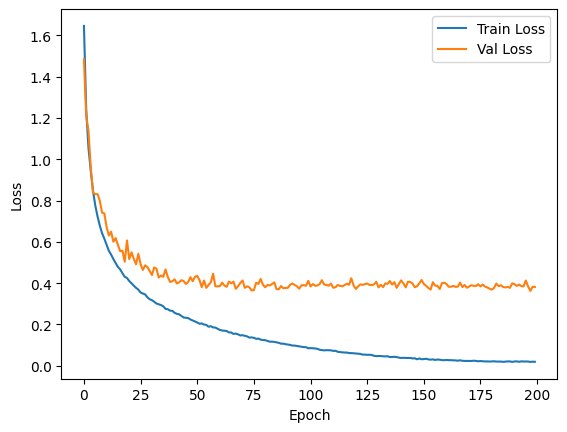

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
num_epochs = 200
learning_rate = 0.008 #moderate learning rate, not too fast not too slow
weight_decay = 1e-4
max_norm = 2.0 #parameter for gradient clipping
patience = 10


#flipping, rotating, normalizing, Affine transformations, cropping as methods of data augmentation.
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# load the CIFAR-10 dataset using torchvision.datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        # layer to perform adaptive average pooling

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Sequential block containing two linear layers with ReLU activation and sigmoid activation

        self.fc = nn.Sequential(
            # the first  linear layer reduces the number of channels by a factor of reduction
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),

            # Second linear layer increases the number of channels back to the original number.
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Retrieve batch size, number of channels, and spatial dimensions oft the  input tensor
        b, c, _, _ = x.size()

        # Apply adaptive average pooling to reduce spatial dimensions to (1, 1)
        y = self.avg_pool(x).view(b, c)

        # Apply the fully connected layers defined in self.fc
        y = self.fc(y).view(b, c, 1, 1)


        # using expand_as to match the dimensions of x
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        # Shortcut connection if input and output dimensions are different
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        # Squeeze-and-Excitation block
        self.se = SEBlock(out_channels)

    def forward(self, x):
        # now save  the residual
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        # adding the residual back to the output
        x += residual
        x = self.relu(x)
        return x

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 32
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        #stack the layers
        self.layer1 = self.make_layer(32, 3, stride=1)
        self.layer2 = self.make_layer(64, 3, stride=2)
        self.layer3 = self.make_layer(128, 3, stride=2)
        self.layer4 = self.make_layer(256, 3, stride=2)
        #global average pooling
        self.avg_pool = nn.AvgPool2d(4)
        #fully connected layer for final classification based on number of classes
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Create the model, optimizer, and scheduler
model = CustomResNet().to(device)

#using SGD optimizer as we saw that it works better than Adam
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

#scheduling to adjust learning rate to improve convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

criterion = nn.CrossEntropyLoss()

# check the number of parameters to ensure that they are below 5 million
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

import matplotlib.pyplot as plt

# Lists to store losses for plotting
train_losses = []
val_losses = []


#training startes here
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #applying optimizer
        outputs = model(inputs)
        loss = criterion(outputs, labels) #cross entropy loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm) #gradient clipping
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100.0 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    train_losses.append(train_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels) #cross entropy loss
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100.0 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Acc: {val_acc:.2f}%')
    val_losses.append(val_loss/len(test_loader))

    # Update the scheduler
    scheduler.step()

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_acc:.2f}%')

# now checking the results on the test dataset
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100.0 * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

# Ploting the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [7]:
import torch
import numpy as np
import pandas as pd
import pickle

#normalize the data
def normalize_data(data):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    data_normalized = (data - mean[:, None, None]) / std[:, None, None]
    return data_normalized

# Load the new CIFAR10 test dataset without labels
with open('cifar_test_nolabels.pkl', 'rb') as f:
    cifar_test_data_dict = pickle.load(f)

#extract the data from the dictionary
cifar_test_data = cifar_test_data_dict[b'data']

# peprocess the data
cifar_test_data = cifar_test_data.astype('float32') / 255.0  # Convert data to float and scale
cifar_test_data = cifar_test_data.reshape(-1, 3, 32, 32)  # Reshape data to match model input
cifar_test_data = normalize_data(cifar_test_data)  # Normalize data

# Convert to PyTorch tensor and move to the appropriate device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cifar_test_data_tensor = torch.tensor(cifar_test_data, dtype=torch.float, device=device)

batch_size = 100
predictions = []

model.eval()

#now making the predictions
with torch.no_grad():
    for i in range(0, cifar_test_data_tensor.size(0), batch_size):
        batch = cifar_test_data_tensor[i:i+batch_size].to(device)
        outputs = model(batch)
        _, batch_predictions = torch.max(outputs, 1)
        predictions.extend(batch_predictions.cpu().numpy())

predictions = np.array(predictions)

#create DataFrame for submission and save to CSV in the format required for the kaggle upload
image_ids = np.arange(len(cifar_test_data))
predictions_df = pd.DataFrame({'ID': image_ids, 'Labels': predictions})
predictions_df.to_csv('predictions_normalized.csv', index=False)
